In [2]:
# imports
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pathlib as Path
import json
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
# Multiclass CNN performance metric functions

def calculate_cnn_precision_multiclass(y_true, y_pred):
    """
    Calculate the precision of a CNN model for a 4-class classifier using one-hot encoding.
    
    Args:
    y_true (numpy.ndarray): Ground truth labels (one-hot encoded)
    y_pred (numpy.ndarray): Predicted probabilities for each class
    
    Returns:
    numpy.ndarray: Precision score for each class
    float: Average precision across all classes
    """
    
    # Convert predicted probabilities to class predictions
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Number of classes
    num_classes = y_true.shape[1]
    
    # Initialize arrays to store true positives and predicted positives
    true_positives = np.zeros(num_classes)
    predicted_positives = np.zeros(num_classes)
    
    # Calculate true positives and predicted positives for each class
    for i in range(num_classes):
        true_positives[i] = np.sum((np.argmax(y_true, axis=1) == i) & (y_pred_classes == i))
        predicted_positives[i] = np.sum(y_pred_classes == i)
    
    # Calculate precision for each class
    precision = true_positives / (predicted_positives + 1e-7)
    
    # Calculate average precision
    average_precision = np.mean(precision)
    
    return precision, average_precision

def calculate_cnn_recall_multiclass(y_true, y_pred):
    """
    Calculate the recall of a CNN model for a 4-class classifier using one-hot encoding.
    
    Args:
    y_true (numpy.ndarray): Ground truth labels (one-hot encoded)
    y_pred (numpy.ndarray): Predicted probabilities for each class
    
    Returns:
    numpy.ndarray: Recall score for each class
    float: Average recall across all classes
    """
    
    # Convert predicted probabilities to class predictions
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Number of classes
    num_classes = y_true.shape[1]
    
    # Initialize arrays to store true positives and actual positives
    true_positives = np.zeros(num_classes)
    actual_positives = np.zeros(num_classes)
    
    # Calculate true positives and actual positives for each class
    for i in range(num_classes):
        true_positives[i] = np.sum((np.argmax(y_true, axis=1) == i) & (y_pred_classes == i))
        actual_positives[i] = np.sum(np.argmax(y_true, axis=1) == i)
    
    # Calculate recall for each class
    recall = true_positives / (actual_positives + 1e-7)
    
    # Calculate average recall
    average_recall = np.mean(recall)
    
    return recall, average_recall

def calculate_cnn_f1_score_multiclass(y_true, y_pred):
    """
    Calculate the F1 score of a CNN model for a 4-class classifier using one-hot encoding.
    
    Args:
    y_true (numpy.ndarray): Ground truth labels (one-hot encoded)
    y_pred (numpy.ndarray): Predicted probabilities for each class
    
    Returns:
    numpy.ndarray: F1 score for each class
    float: Average F1 score across all classes
    """
    
    # Calculate precision and recall
    precision, _ = calculate_cnn_precision_multiclass(y_true, y_pred)
    recall, _ = calculate_cnn_recall_multiclass(y_true, y_pred)
    
    # Calculate F1 score for each class
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    # Calculate average F1 score
    average_f1_score = np.mean(f1_score)
    
    return f1_score, average_f1_score

def calculate_cnn_accuracy_multiclass(y_true, y_pred):
    """
    Calculate the accuracy of a CNN model for a 4-class classifier using one-hot encoding.
    
    Args:
    y_true (numpy.ndarray): Ground truth labels (one-hot encoded)
    y_pred (numpy.ndarray): Predicted probabilities for each class
    
    Returns:
    numpy.ndarray: Accuracy score for each class
    float: Overall accuracy across all classes
    """
    
    # Convert predicted probabilities to class predictions
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)
    
    # Number of classes
    num_classes = y_true.shape[1]
    
    # Initialize arrays to store correct predictions and total predictions
    correct_predictions = np.zeros(num_classes)
    total_predictions = np.zeros(num_classes)
    
    # Calculate correct predictions and total predictions for each class
    for i in range(num_classes):
        correct_predictions[i] = np.sum((y_true_classes == i) & (y_pred_classes == i))
        total_predictions[i] = np.sum(y_true_classes == i)
    
    # Calculate accuracy for each class
    class_accuracy = correct_predictions / (total_predictions + 1e-7)
    
    # Calculate overall accuracy
    overall_accuracy = np.sum(correct_predictions) / len(y_true_classes)
    
    return class_accuracy, overall_accuracy

In [4]:
# functions

def find_json_file(directory):
    """
    Find a JSON file in a directory (and its subdirectories) and load it into a dictionary.
    
    Parameters:
        directory (str): Path to the directory to search.
    
    Returns:
        dict or None: Dictionary containing the JSON data if a file is found, 
                      None otherwise.
    """
    for root, dirs, files in os.walk(directory):
        for file_name in files:
            if file_name.endswith('.json'):
                file_path = os.path.join(root, file_name)
                with open(file_path, 'r') as file:
                    try:
                        json_data = json.load(file)
                        return json_data
                    except json.JSONDecodeError:
                        print(f"Error: JSON decode failed for file '{file_path}'")
    print("No JSON file found in the directory.")
    return None

def one_hot_encode_max(arr):
    # Ensure the array is a numpy array for efficient processing
    arr = np.array(arr)
    
    # Create an array of zeros with the same shape as the input
    one_hot = np.zeros_like(arr)
    
    # For each row, set the position of the max value to 1
    max_indices = np.argmax(arr, axis=1)  # Get index of max value in each row
    one_hot[np.arange(arr.shape[0]), max_indices] = 1  # Set 1 at max index positions
    
    return one_hot

def find_threshold(y_pred, y_true, threshold_range=np.arange(0.5, 1.0, 0.02)):

    # Get the indices of the highest values for each array
    true_max_indices = np.argmax(y_true, axis=1)
    pred_max_indices = np.argmax(y_pred, axis=1)

    # Get the highest predicted values
    pred_max_values = np.max(y_pred, axis=1)

    best_f1 = 0
    best_threshold = 0

    # Loop over the threshold range to find the best threshold
    for threshold in threshold_range:
        # Create a mask where the indices match and values are above threshold
        final_mask = (true_max_indices == pred_max_indices) & (pred_max_values >= threshold)

        # Create output array of zeros with the same shape as y_pred
        output = np.zeros_like(y_pred)

        # Set values where conditions are met
        output[final_mask] = y_pred[final_mask]

        output = one_hot_encode_max(output)
        
        # Calculate precision, recall, F1-score for this threshold
        precision = precision_score(y_true, output, average='weighted', zero_division=0)
        recall = recall_score      (y_true, output, average='weighted', zero_division=0)
        f1 = f1_score              (y_true, output, average='weighted', zero_division=0)

        # print(f'Threshold: {threshold}, Precision: {precision}, Recall: {recall}, F1: {f1}')

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Create a mask where the indices match and values are above threshold
    final_mask = (true_max_indices == pred_max_indices) & (pred_max_values >= best_threshold)

    # Create output array of zeros with the same shape as y_pred
    output = np.zeros_like(y_pred)

    # Set values where conditions are met
    output[final_mask] = y_pred[final_mask]

    output = one_hot_encode_max(output)

    # Calculate precision, recall, F1-score for this threshold
    precision = precision_score(y_true, output, average=None, zero_division=0)
    recall = recall_score      (y_true, output, average=None, zero_division=0)
    f1 = f1_score              (y_true, output, average=None, zero_division=0)
    
    print(output)
    print(y_true)

    print(precision)
    print(recall)
    print(f1)

    print(f'Best Threshold: {best_threshold} with F1 Score: {best_f1}')
    
    return best_threshold, best_f1

def find_earliest_percent_bin(histogram,per):
    """
    Finds the earliest bin containing 90% of the values in a histogram.

    Args:
    histogram: A list of tuples, where each tuple represents a bin and contains
    the bin's lower bound and frequency.

    Returns:
    The index of the earliest bin containing 90% of the values.
    """

    total_data_points = sum(freq for freq in histogram)
    ninety_percent_threshold = int(per / 100 * total_data_points)

    print(total_data_points)
    print(ninety_percent_threshold)

    running_total = 0
    for i, freq in enumerate(histogram):
        running_total += freq
        if running_total >= ninety_percent_threshold:
            print(running_total)
            return i

    # If % threshold is not reached, return the last bin index
    return len(histogram) - 1

def find_earliest_percent_bin_above(histogram, per):
    """
    Finds the earliest bin above which lie a certain percentage of the values in a histogram.

    Args:
    histogram: A list of tuples, where each tuple represents a bin and contains
    the bin's lower bound and frequency.
    per: The percentage of values to be found above the returned bin.

    Returns:
    The index of the earliest bin above which lie the given percentage of the values.
    """

    total_data_points = sum(freq for freq in histogram)
    threshold = int(per / 100 * total_data_points)

    print(total_data_points)
    print(threshold)

    running_total = 0
    for i in reversed(range(len(histogram))):  # Start from the end of the histogram
        running_total += histogram[i]
        if running_total >= threshold:
            print(running_total)
            return i

    # If the % threshold is not reached, return the first bin index
    return 0

def analyze_predictions(predicted_values, true_values):  # roc method
    correct_confidences = []
    incorrect_confidences = []
    
    for pred, true in zip(predicted_values, true_values):
        predicted_class = np.argmax(pred)
        true_class = np.argmax(true)
        confidence = np.max(pred)
        
        if predicted_class == true_class:
            correct_confidences.append(confidence)
        else:
            incorrect_confidences.append(confidence)

    # Combine confidences and create binary labels
    all_confidences = np.array(correct_confidences + incorrect_confidences)
    all_labels = np.array([1] * len(correct_confidences) + [0] * len(incorrect_confidences))
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_confidences)
    roc_auc = auc(fpr, tpr)
    
    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    print('data size',len(correct_confidences) + len(incorrect_confidences))
    print('number of "correct" predictions', len(correct_confidences))
    print('number of "incorrect" predictions', len(incorrect_confidences))

    num_bins = 100
    bin_range = (0,1)
    # Compute histograms with the same range and bins
    hist1, bins = np.histogram(correct_confidences, bins=num_bins, range=bin_range,density=False)
    hist2, _ = np.histogram(incorrect_confidences, bins=num_bins, range=bin_range,density= False)

    # Set the bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Some percent of correct 
    cper = 90
    lates = bin_centers[find_earliest_percent_bin_above(hist1,cper)]

    # 90% of incorrect
    per = 90
    earlies = bin_centers[find_earliest_percent_bin(hist2,per)]

    hist1 = hist1  / (len(predicted_values))  
    hist2 = hist2  / (len(predicted_values))  

    # Plot histograms
    plt.figure(figsize=(8, 6))

    # Plot the first histogram (going up)
    plt.bar(bin_centers, hist1, width=(bins[1] - bins[0]), color='blue', alpha=0.5, label='Correct confidences')

    # Plot the second histogram (going down)
    plt.bar(bin_centers, -hist2, width=(bins[1] - bins[0]), color='red', alpha=0.5, label='Incorrect confidences')

    # Add labels and title
    plt.xlabel('Confidence Value')
    plt.ylabel('Frequency')
    plt.title('Histograms of correct and incorrect confidence')

    print('Total accuracy on the given data :',len(correct_confidences)/ (len(correct_confidences) + len(incorrect_confidences)))
    plt.grid('True')
    
    # find the average confidences for correct and incorrect predictions
    avg_correct_confidence = np.mean(correct_confidences) if correct_confidences else 0
    avg_incorrect_confidence = np.mean(incorrect_confidences) if incorrect_confidences else 0

    # Take the mean between them
    threshold = (avg_correct_confidence + avg_incorrect_confidence) / 2

    # plot the threshold value
    plt.axvline(threshold, label = 'threshold by means',color = 'g')

    # plot optimal threshold using ROC AUC
    # plt.axvline(optimal_threshold,label = 'optimal ROC threshold', color = 'y')

    # plt.axvline(earlies,label = f'{per}% of incorrect predictions', color = 'r')

    # plt.axvline(lates,label = f'{cper}% of correct predictions', color = 'b')

    
    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

    return avg_correct_confidence, avg_incorrect_confidence, optimal_threshold, roc_auc, fpr, tpr, thresholds

# function to optimize for f1 score
def optimize_threshold_f1(predicted_values, true_values, num_classes=4):
    def apply_threshold(predictions, threshold):
        return (predictions >= threshold).astype(int)

    # Convert true_values to one-hot encoding if not already
    if true_values.ndim == 1:
        true_values = label_binarize(true_values, classes=range(num_classes))

    thresholds = np.linspace(0, 1, 100)
    f1_scores = []

    for threshold in thresholds:
        # Apply threshold to predicted probabilities
        thresholded_preds = np.apply_along_axis(apply_threshold, 1, predicted_values, threshold)
        
        # Calculate macro F1 score
        macro_f1 = f1_score(true_values, thresholded_preds, average='macro')
        f1_scores.append(macro_f1)

    # Find the threshold that maximizes the F1 score
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]
    best_f1_score = f1_scores[best_threshold_idx]

    return best_threshold, best_f1_score, thresholds, f1_scores

#Function for unidentified class
def predict_with_unidentified(model, data, threshold=0.7):
    predictions = model.predict(data)
    max_prob = np.max(predictions, axis=1)
    labels = np.argmax(predictions, axis=1)
    labels[max_prob < threshold] = 4
    
    unidentified_count = np.sum(max_prob < threshold)
    return labels, unidentified_count

#using the threshold for analyzing
def analyze_predictions_with_threshold(predicted_values, true_values, confidence_threshold):
    confidently_right = 0
    confidently_wrong = 0
    uncertain = 0
    total = len(predicted_values)
    
    for pred, true in zip(predicted_values, true_values):
        predicted_class = np.argmax(pred)
        true_class = np.argmax(true)
        confidence = np.max(pred)
        
        if confidence >= confidence_threshold:
            if predicted_class == true_class:
                confidently_right += 1
            else:
                confidently_wrong += 1
        else:
            uncertain += 1
    
    percent_confidently_right = (confidently_right / total) * 100
    percent_confidently_wrong = (confidently_wrong / total) * 100
    percent_uncertain = (uncertain / total) * 100
    
    return percent_confidently_right, percent_confidently_wrong, percent_uncertain


Arpan's model MI-DCL

In [5]:
# Path
dir_path = r"C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_uncertain" 

# Check if the path exists
if os.path.exists(dir_path):
    print(f"The path '{dir_path}' exists.")
else:
    print(f"The path '{dir_path}' does not exist.")


# importing data
event_types = {1:'UNCERT',2:'UNRELOC'}

test_dir = os.path.join(dir_path,"test")  
train_dir = os.path.join(dir_path,"train")

# Replace 'your_search_string' with the string you are looking for in file names
search_string = 'bn'

search_pattern = os.path.join(test_dir, f'*{search_string}*')
test_files = glob.glob(search_pattern)

search_pattern = os.path.join(train_dir, f'*{search_string}*')
train_files = glob.glob(search_pattern)

json_data = find_json_file(dir_path)
print(json_data)

dno = json_data['number of data points']

try:
    inup = json_data['include unprocessed']
except:
    inup = False
try:
    chrn = json_data['channel ranges']
except:
    chrn = 1
    
try:
    t = json_data['time interval'][1]-json_data['time interval'][0]
except:
    t='n/a'
    
# Calculating the number of points in each binnning
bin_list = json_data['bin list']
extra = 2 if inup else 1
dno_list = (len(bin_list)) * (len(chrn)*extra)  * [dno]
data_total = sum(dno_list)

fileno = 42

# Open the file in read mode
with open(train_files[fileno], 'r') as file:
    # Read all lines into a list
    lines = file.readlines()
print('hello',train_files[fileno],len(lines))

check_data = np.loadtxt(train_files[fileno], delimiter=' ').astype(np.int32)
len_data = len(check_data)

print(dno_list)
if data_total == len_data and len(dno_list) == (len(bin_list)) * (len(chrn)*extra):
    print('bin edges calculated correctly')
    print(data_total)
    print(len_data)
else:
    print('inconsistency in bin edges calculated and data')
    print(data_total)
    print(len_data)
    
print('channel range no',chrn)
print('number of data points',dno)
print('time interval',t)



def process_file(file, X,Y,event_counter,inup = inup, dno_list = dno_list): # for MI-DCL
    """
    takes a file and processes it and adds it to the data set
    file:path to the file to be processed
    X:data set to be added to
    Y:list of labels of data
    dno_list:list of number of data points in each binning as calculated previously
    
    returns updated X and Y and event_counter
    """
    # fetching data from file and checking if label is considered
    event_type , event_name = file.split('\\')[-1].split('_') # changed here for difference in path structure
    loaded_data = np.loadtxt(file, delimiter='\t').astype(np.float32)
    if event_type not in event_counter.keys():
        return X,Y,event_counter
    
    y = [0,0,0,0]
    
    # setting and updating Y
    for key,value in event_types.items():
        if value in file.split('\\')[-1]:
            y[key-1] = 1
            Y.append(y)
            event_counter[value] += 1
            
    extra = 2 if inup else 1
    
    # setting and updating X
    f = 0
    for k,dno in zip(X.keys(),dno_list):
        datlist = []
        for i in range(len(chrn) * extra):
            datlist.append(loaded_data[f:f+dno])
            f = f + int(dno)
#         print(len(datlist))
        X[k].append(np.array(datlist).transpose())
        
    return X,Y,event_counter

# initializing train and test sets
X_train = {str(key): [] for key in bin_list}
Y_train = []
train_event_counter = {'UNCERT':0, 'UNRELOC':0}

X_test = {str(key): [] for key in bin_list}
Y_test = []
test_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

# print(process_file(train_files[1],X_train,Y_train,train_event_counter,inup))

# processing train and test data sets for MI-DCL
for file in train_files[:]:
    X_train,Y_train,train_event_counter = process_file(file,X_train,Y_train,train_event_counter,inup = inup, dno_list = dno_list)
print('training events\n',train_event_counter)
print('total events : ', sum([i for i in train_event_counter.values()]))
Y_train = np.array(Y_train)
print('shape of Y_train', Y_train.shape)
print('shape of X_train dictionary:')
for i in X_train.keys():
    X_train[i] = np.array(X_train[i])
#     X_train[i] = np.reshape(X_train[i], X_train[i].shape + tuple([1]))
    print(type(X_train[i]),X_train[i].shape)

for file in test_files[:]:
    X_test,Y_test,test_event_counter = process_file(file,X_test,Y_test,test_event_counter,inup = inup, dno_list = dno_list)
print('testing events\n',test_event_counter)
print('total events : ', sum([i for i in test_event_counter.values()]))
Y_test = np.array(Y_test)
print('shape of Y_test', Y_test.shape)
print('shape of X_test dictionary:')
for i in X_test.keys():
    X_test[i] = np.array(X_test[i])
#     X_test[i] = np.reshape(X_test[i], X_test[i].shape + tuple([1]))
    print(type(X_test[i]),X_test[i].shape)

The path 'C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_uncertain' exists.
{'bin list': [0.001, 0.004, 0.016, 0.064, 0.256, 1.024, 4.096], 'time interval': 'n/a', 'number of data points': 499, 'data set name': 'DCL_test', 'data set path': 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_test', 'channel ranges': [[3, 50], [51, 124]], 'ratio': 0.5, 'type': 'hrates', 'include unprocessed': False}
hello C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_uncertain\train\UNCERT_bn211221163 6986
[499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499]
bin edges calculated correctly
6986
6986
channel range no [[3, 50], [51, 124]]
number of data points 499
time interval n/a
training events
 {'UNCERT': 50, 'UNRELOC': 25}
total events :  75
shape of Y_train (75, 4)
shape of X_train dictionary:
<class 'numpy.ndarray'> (75, 499, 2)
<class 'numpy.ndarray'> (75, 499, 2)
<class 'numpy.ndarray'> (75, 499, 2)
<class 'numpy.ndarray'> (75, 499, 2)
<class 'numpy.ndarray'> (75, 499, 2)
<cla

In [6]:
print(train_files)

['C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_uncertain\\train\\UNCERT_bn091022752', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_uncertain\\train\\UNCERT_bn100303194', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_uncertain\\train\\UNCERT_bn100402447', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_uncertain\\train\\UNCERT_bn100617514', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_uncertain\\train\\UNCERT_bn100729415', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_uncertain\\train\\UNCERT_bn100909220', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_uncertain\\train\\UNCERT_bn101027186', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_uncertain\\train\\UNCERT_bn110519623', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_uncertain\\train\\UNCERT_bn110703526', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_uncertain\\train\\UNCERT_bn110822775', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_unce

In [7]:
# Load the model
from keras.models import load_model
model_path = r"C:\Users\arpan\OneDrive\Desktop\models\midcl3\MI-DCL.keras" # MI-DCL model
model = load_model(model_path)
# model.summary()

In [8]:
y_pred = model.predict(X_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step


In [9]:
import matplotlib.pyplot as plt
import numpy as np

threshold = 0.6


def predict_with_unidentified(model, data, threshold=0.6):
    predictions = model.predict(data)
    max_prob = np.max(predictions, axis=1)
    labels = np.argmax(predictions, axis=1)
    labels[max_prob < threshold] = 4
    
    unidentified_count = np.sum(max_prob < threshold)
    return labels, max_prob,unidentified_count

result,max_prob, count = predict_with_unidentified(model, X_train, threshold)
print(result)
print(count)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[0 1 1 3 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 1 1 1 1 1 4 1 1 1 3 1 1 3 1 1
 1 1 1 1 4 1 0 1 1 1 1 1 2 3 1 1 1 1 1 1 0 1 3 1 1 3 1 3 3 0 1 1 1 1 3 0 4
 1]
3


(array([ 3.,  0.,  0.,  1.,  0., 25.,  0.,  3.,  0.,  1.,  1.,  1.,  1.,
         1.,  5.,  2.,  4.,  7.,  3., 17.]),
 array([0.55191547, 0.57426947, 0.59662354, 0.61897755, 0.64133161,
        0.66368562, 0.68603963, 0.70839369, 0.7307477 , 0.75310177,
        0.77545577, 0.79780978, 0.82016385, 0.84251785, 0.86487192,
        0.88722593, 0.90957993, 0.931934  , 0.95428801, 0.97664207,
        0.99899608]),
 <BarContainer object of 20 artists>)

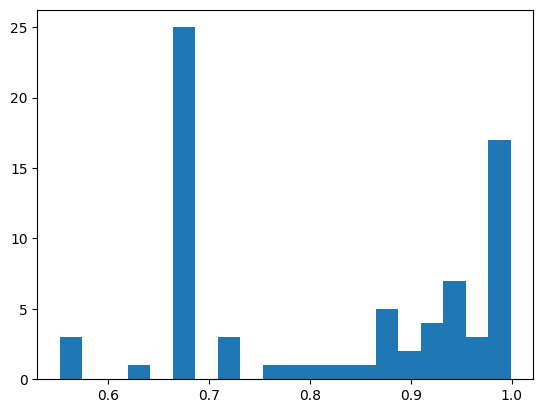

In [10]:
plt.hist(max_prob, bins = 20)

In [11]:
# Make predictions - this gives probability scores
y_pred = model.predict(X_test)

# Convert probability scores to class predictions
y_pred_mod = np.argmax(y_pred, axis=1)

# Convert one-hot encoded Y_test to class labels if needed
if len(Y_test.shape) > 1:  # If Y_test is one-hot encoded
    Y_test_mod = np.argmax(Y_test, axis=1)

# Import necessary metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# Calculate basic metrics
accuracy = accuracy_score(Y_test_mod, y_pred_mod)
precision = precision_score(Y_test_mod, y_pred_mod, average='weighted')
recall = recall_score(Y_test_mod, y_pred_mod, average='weighted')
f1 = f1_score(Y_test_mod, y_pred_mod, average='weighted')

# Calculate confusion matrix

conf_m = confusion_matrix(Y_test_mod, y_pred_mod)

conf_m_show = ConfusionMatrixDisplay(confusion_matrix = conf_m,display_labels=['GRB','TGF','SGR','SFLARE'])
conf_m_show.plot(include_values=True, cmap='Blues',ax = None, xticks_rotation= 'horizontal')
plt.show()

# Print results
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nConfusion Matrix:")
print(conf_m)

print("\nDetailed Classification Report:")
print(classification_report(Y_test_mod, y_pred_mod))

# If you want to see probabilities for specific examples
print("\nProbability Scores for First 5 Examples:")
for i in range(min(5, len(y_pred))):
    print(f"Example {i+1}: {y_pred[i]}")

c:\Users\arpan\miniconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ValueError: math domain error

data size 3200
number of "correct" predictions 3033
number of "incorrect" predictions 167
3033
2729
2733
167
150
150
Total accuracy on the given data : 0.9478125


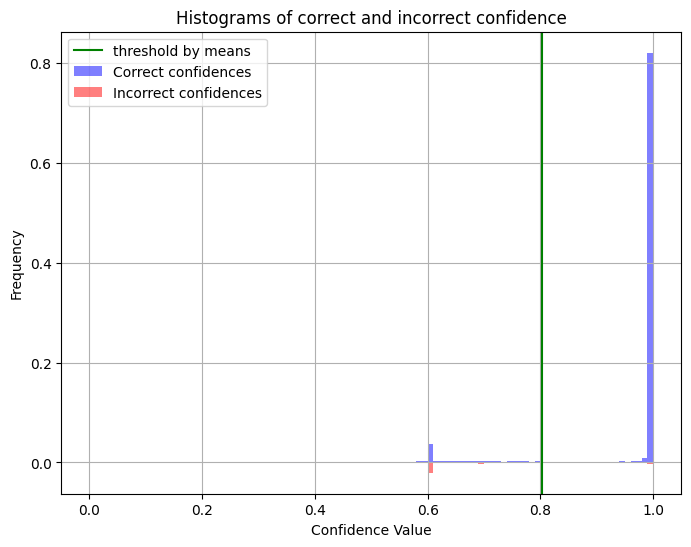

Average confidence for correct predictions: 0.9610
Average confidence for incorrect predictions: 0.6437
mean threshold 0.8023767471313477


In [11]:
# analyze training data to find threshold

avg_correct, avg_incorrect,roc_threshold, roc_auc, fpr, tpr, thresholds = analyze_predictions(y_pred_train, Y_train)

print(f"Average confidence for correct predictions: {avg_correct:.4f}")
print(f"Average confidence for incorrect predictions: {avg_incorrect:.4f}")

mean_threshold = (avg_correct + avg_incorrect ) / 2

print(f"mean threshold {mean_threshold}")
 



In [12]:
# Lists to store True Positive (TP), False Negative (FN), False Positive (FP), and Below Threshold (BT) cases for TGF
tp_TGF = []  # True Positive TGF
fn_TGF = []  # False Negative TGF
fp_TGF = []  # False Positive TGF
bt_TGF = []  # Below threshold TGF

# Iterate over test files and classify based on model predictions and thresholds
for i, file in enumerate(test_files):
    tc = np.argmax(Y_test[i])  # True class
    pc = np.argmax(y_pred[i])  # Predicted class
    
    # Handle True Positive TGF (correct classification and prediction confidence above threshold)
    if 'TGF_' in file:
        if y_pred[i][pc] > mean_threshold and pc == tc:
            tp_TGF.append(file)
        # Handle False Negative TGF (incorrect classification)
        elif tc != pc:
            fn_TGF.append(file)
        # Handle Below Threshold TGF (correct classification but prediction confidence below threshold)
        elif y_pred[i][pc] < mean_threshold and pc == tc:
            bt_TGF.append(file)
    
    # Handle False Positive TGF (prediction as TGF, but file is not TGF and confidence is above threshold)
    elif 'TGF_' not in file:
        if pc == 1 and y_pred[i][pc] > mean_threshold:
            fp_TGF.append(file)

# Print the results
print("Number of True Positives (TGF):",  len(tp_TGF))
print("Number of False Negatives (TGF):", len(fn_TGF))
print("Number of False Positives (TGF):", len(fp_TGF))
print("Number of Below Threshold (TGF):", len(bt_TGF))

print("True Positives (TGF):",  tp_TGF)
print("False Negatives (TGF):", fn_TGF)
print("False Positives (TGF):", fp_TGF)
print("Below Threshold (TGF):", bt_TGF)


Number of True Positives (TGF): 125
Number of False Negatives (TGF): 6
Number of False Positives (TGF): 0
Number of Below Threshold (TGF): 69
True Positives (TGF): ['C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds2new\\test\\TGF_bn081001392', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds2new\\test\\TGF_bn091118985', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds2new\\test\\TGF_bn100207843', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds2new\\test\\TGF_bn100331421', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds2new\\test\\TGF_bn100411366', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds2new\\test\\TGF_bn100426657', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds2new\\test\\TGF_bn100501559', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds2new\\test\\TGF_bn100515316', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds2new\\test\\TGF_bn100606292', 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\D

data size 784
number of "correct" predictions 723
number of "incorrect" predictions 61
723
650
650
61
54
61
Total accuracy on the given data : 0.9221938775510204


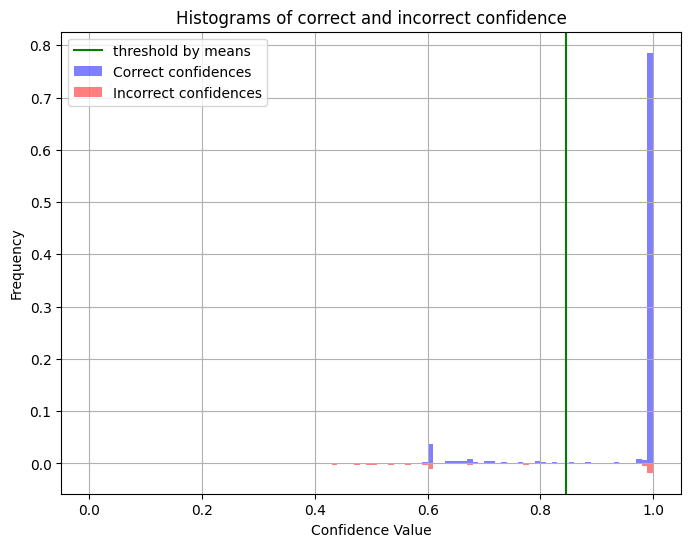

Average confidence for correct predictions: 0.9586
Average confidence for incorrect predictions: 0.7336
optimal_threshold :0.9982043504714966


In [13]:
# Analyse test data
avg_correct, avg_incorrect,roc_threshold_test, roc_auc, fpr, tpr, thresholds = analyze_predictions(y_pred, Y_test)

print(f"Average confidence for correct predictions: {avg_correct:.4f}")
print(f"Average confidence for incorrect predictions: {avg_incorrect:.4f}")
 

# print(f'thresholds :{thresholds}')
print(f'optimal_threshold :{roc_threshold_test}')


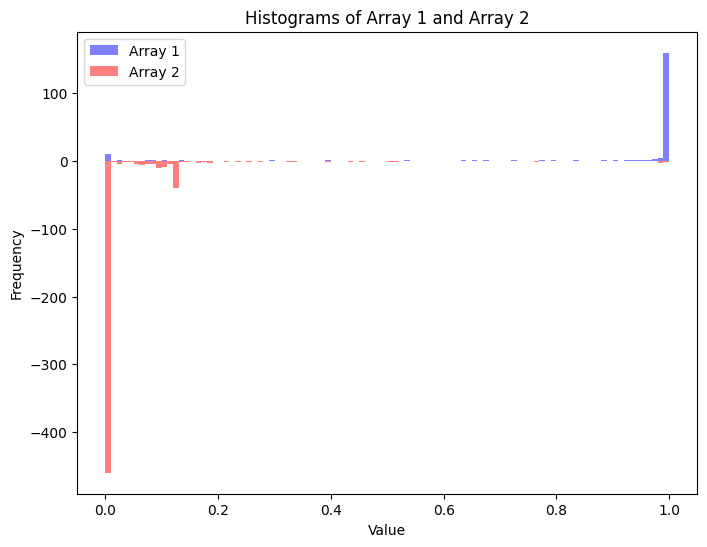

784, 200, 584
class 0 cor conf 0.9052624702453613
class 0 incor conf 0.037468187510967255


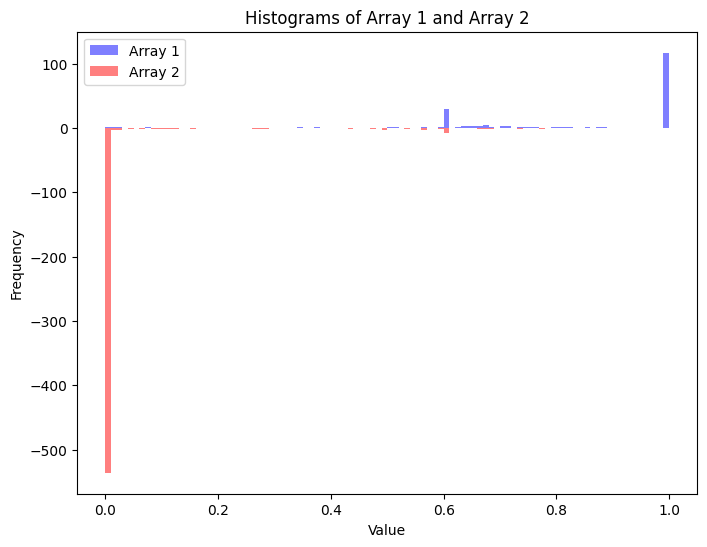

784, 200, 584
class 1 cor conf 0.8418735265731812
class 1 incor conf 0.03112148307263851


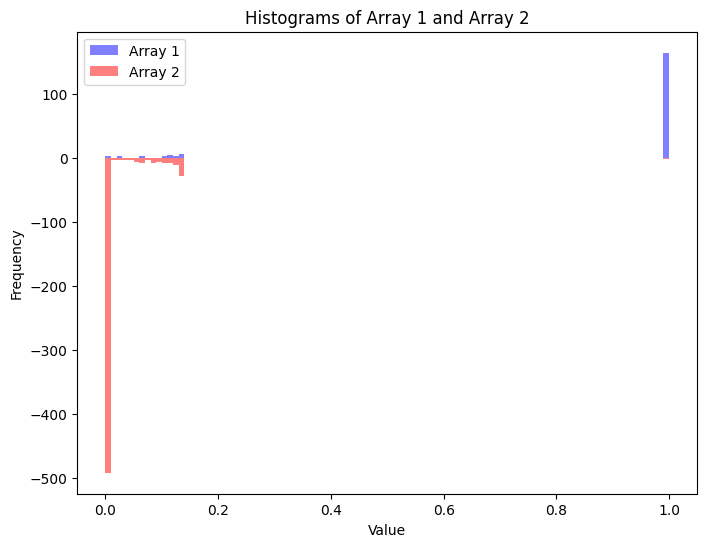

784, 184, 600
class 2 cor conf 0.9015178084373474
class 2 incor conf 0.02187621220946312


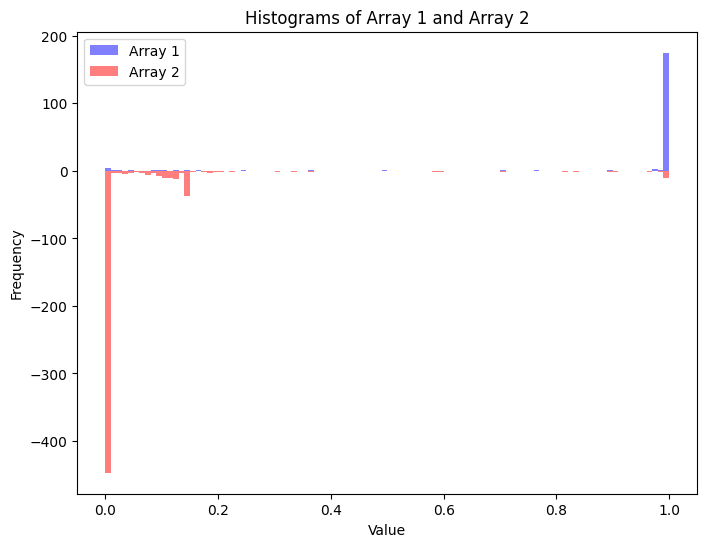

784, 200, 584
class 3 cor conf 0.9191111922264099
class 3 incor conf 0.05426236614584923


In [14]:
# # prob dist classwise

# for i in range(4):

#     one_hot_coding_mask = Y_test[:,i].astype(bool)
#     inv_one_hot_coding_mask = ~ one_hot_coding_mask

#     class_i_correct_conf = y_pred[:,i][one_hot_coding_mask]
#     class_i_incorrect_conf = y_pred[:,i][inv_one_hot_coding_mask]

#     num_bins = 100
#     bin_range = (0,1)
#     # Compute histograms with the same range and bins
#     hist1, bins = np.histogram(class_i_correct_conf, bins=num_bins, range=bin_range,density=False)
#     hist2, _ = np.histogram(class_i_incorrect_conf, bins=num_bins, range=bin_range,density= False)

#     hist1 = hist1  #/ (len(hist1) + len(hist2))
#     hist2 = hist2  #/ (len(hist2) + len(hist1))

#     # Set the bin centers for plotting
#     bin_centers = (bins[:-1] + bins[1:]) / 2

#     # Plot histograms
#     plt.figure(figsize=(8, 6))

#     # Plot the first histogram (going up)
#     plt.bar(bin_centers, hist1, width=(bins[1] - bins[0]), color='blue', alpha=0.5, label='Array 1')

#     # Plot the second histogram (going down)
#     plt.bar(bin_centers, -hist2, width=(bins[1] - bins[0]), color='red', alpha=0.5, label='Array 2')

#     # Add labels and title
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
#     plt.title('Histograms of Array 1 and Array 2')

#     # Add a legend
#     plt.legend()

#     # Show the plot
#     plt.show()


#     print(f'{len(Y_test)}, {len(class_i_correct_conf)}, {len(class_i_incorrect_conf)}')

#     print(f'class {i} cor conf {np.mean(class_i_correct_conf)}')
#     print(f'class {i} incor conf {np.mean(class_i_incorrect_conf)}')


In [15]:
def calculate_classwise_confidence_thresholds(predictions, Y, num_classes):

    max_probs = np.max(predictions, axis=1)
    predicted_labels = np.argmax(predictions, axis=1)
    # if Y is one-hot encoded
    if Y.ndim == 2: 
        true_labels = np.argmax(Y, axis=1)
    else:  
        true_labels = Y
    
    classwise_thresholds = {}

    for class_idx in range(num_classes):
        # Filter predictions class
        correct_class_mask = (true_labels == class_idx) & (predicted_labels == class_idx)
        if np.sum(correct_class_mask) > 0: 
            avg_confidence = np.mean(max_probs[correct_class_mask])
            classwise_thresholds[class_idx] = avg_confidence
        else:
            classwise_thresholds[class_idx] = None  # If no correct predictions 
    return classwise_thresholds

classwise_thresholds = calculate_classwise_confidence_thresholds(y_pred, Y_test, num_classes=4)
print(f'Class-specific confidence thresholds: {classwise_thresholds}')


Class-specific confidence thresholds: {0: 0.98314613, 1: 0.8654293, 2: 1.0, 3: 0.9959668}


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step

Accuracy on training data with unidentified class: 0.8515625


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Yes
Accuracy on test data with unidentified class: 0.8227040816326531
Number of unidentified instances in training data: 454 out of 3200 ( or ) 14.1875%
Number of unidentified instances in test data: 115 out of 784 ( or ) 14.668367346938776%
confusion matrix


<Figure size 1000x700 with 0 Axes>

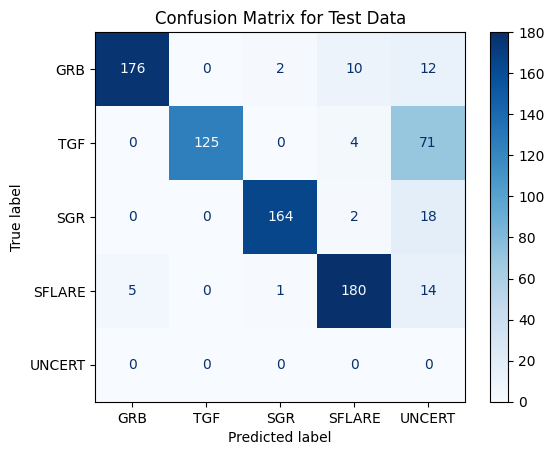

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# the threshold used in final analysis
threshold = mean_threshold

# Evaluate on training data
train_predictions, train_unidentified_count = predict_with_unidentified(model, X_train, threshold)
train_accuracy = np.mean(train_predictions == np.argmax(Y_train, axis=1))
print(f'\nAccuracy on training data with unidentified class: {train_accuracy}\n\n')

# Evaluate on validation data
test_predictions, test_unidentified_count = predict_with_unidentified(model, X_test, threshold)

# Check if Y_test is one-hot encoded or not
if Y_test.ndim > 1:
    print("Yes")
    test_true_labels = np.argmax(Y_test, axis=1)
else:
    test_true_labels = Y_test

test_accuracy = np.mean(test_predictions == test_true_labels)
print(f'Accuracy on test data with unidentified class: {test_accuracy}')

print(f'Number of unidentified instances in training data: {train_unidentified_count} out of {len(Y_train)} ( or ) {train_unidentified_count/len(Y_train) * 100}%')
print(f'Number of unidentified instances in test data: {test_unidentified_count} out of {len(Y_test)} ( or ) {test_unidentified_count/len(Y_test) * 100}%')

print("confusion matrix")
conf_matrix = confusion_matrix(test_true_labels, test_predictions, labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['GRB', 'TGF', 'SGR', 'SFLARE', 'UNCERT'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Data')
plt.show()

In [17]:
# Percentages of test data with confidence

percent_right, percent_wrong, percent_uncertain = analyze_predictions_with_threshold(y_pred, Y_test, threshold)

print(f"Percentage of confidently right predictions: {percent_right:.2f}%")
print(f"Percentage of confidently wrong predictions: {percent_wrong:.2f}%")
print(f"Percentage of uncertain predictions: {percent_uncertain:.2f}%")
print(f"Accuracy of predictions given the model is confident :{percent_right/ (percent_right+percent_wrong)}")

Percentage of confidently right predictions: 82.27%
Percentage of confidently wrong predictions: 3.06%
Percentage of uncertain predictions: 14.67%
Accuracy of predictions given the model is confident :0.9641255605381166
